## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras import regularizers
def build_mlp(input_shape, output_unit=10, num_neurons=[512, 256, 128], use_bn=True, drp_ratio=0, l2_ratio=0):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_uits in enumerate(num_neurons):
        if i==0:
            x = keras.layers.Dense(units=n_uits,
                                  kernel_regularizer=regularizers.l2(l2_ratio),
                                  name='hidden_layer'+str(i+1))(input_layer)
            if use_bn:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_uits,
                                  kernel_regularizer=regularizers.l2(l2_ratio),
                                  name='hidden_layer'+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
                x = Dropout(drp_ratio)(x)
    out = keras.layers.Dense(units=output_unit, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
"""Code Here
設定超參數
"""
LEARNING_RATE=1e-3
EPOCHS=3
BATCH_SIZE=128

USE_BN=[True, False]
DRP_RATIO=[0, 0.4, 0.8]
L2_RATIO=[0, 1e-6, 1e-8]

In [18]:
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    print('Number of exp: %i, with bn: %s, drp_ratio: %.8f, l2_ratio: %.8f'%(i, use_bn, drp_ratio, l2_ratio))

Number of exp: 0, with bn: True, drp_ratio: 0.00000000, l2_ratio: 0.00000000
Number of exp: 1, with bn: True, drp_ratio: 0.00000000, l2_ratio: 0.00000100
Number of exp: 2, with bn: True, drp_ratio: 0.00000000, l2_ratio: 0.00000001
Number of exp: 3, with bn: True, drp_ratio: 0.40000000, l2_ratio: 0.00000000
Number of exp: 4, with bn: True, drp_ratio: 0.40000000, l2_ratio: 0.00000100
Number of exp: 5, with bn: True, drp_ratio: 0.40000000, l2_ratio: 0.00000001
Number of exp: 6, with bn: True, drp_ratio: 0.80000000, l2_ratio: 0.00000000
Number of exp: 7, with bn: True, drp_ratio: 0.80000000, l2_ratio: 0.00000100
Number of exp: 8, with bn: True, drp_ratio: 0.80000000, l2_ratio: 0.00000001
Number of exp: 9, with bn: False, drp_ratio: 0.00000000, l2_ratio: 0.00000000
Number of exp: 10, with bn: False, drp_ratio: 0.00000000, l2_ratio: 0.00000100
Number of exp: 11, with bn: False, drp_ratio: 0.00000000, l2_ratio: 0.00000001
Number of exp: 12, with bn: False, drp_ratio: 0.40000000, l2_ratio: 0.0

In [15]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    keras.backend.clear_session()
    print('Number of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f'%(i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=optimizer)
    
    model.fit(x_train,y_train,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             validation_data=(x_test,y_test),
             verbose=1,
             shuffle=True)
    
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Number of exp: 0, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____________________________________________________________

Epoch 2/3
50000/50000 [==============================] - 22s 447us/step - loss: 1.3756 - acc: 0.5086 - val_loss: 1.8006 - val_acc: 0.3598
Epoch 3/3
50000/50000 [==============================] - 22s 432us/step - loss: 1.2582 - acc: 0.5522 - val_loss: 1.7497 - val_acc: 0.3894
Number of exp: 3, with bn: True, drp_ratio: 0.40, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
________________________________________________

Epoch 2/3
50000/50000 [==============================] - 23s 466us/step - loss: 1.6748 - acc: 0.3961 - val_loss: 1.6317 - val_acc: 0.4121
Epoch 3/3
50000/50000 [==============================] - 23s 454us/step - loss: 1.5878 - acc: 0.4334 - val_loss: 1.5498 - val_acc: 0.4556
Number of exp: 6, with bn: True, drp_ratio: 0.80, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
________________________________________________

50000/50000 [==============================] - 24s 488us/step - loss: 2.6465 - acc: 0.1409 - val_loss: 2.1298 - val_acc: 0.2446
Epoch 2/3
50000/50000 [==============================] - 25s 494us/step - loss: 2.1229 - acc: 0.1947 - val_loss: 2.0217 - val_acc: 0.2596
Epoch 3/3
50000/50000 [==============================] - 24s 476us/step - loss: 2.0243 - acc: 0.2278 - val_loss: 1.8949 - val_acc: 0.2984
Number of exp: 9, with bn: False, drp_ratio: 0.00, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
___________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 17s 345us/step - loss: 14.4596 - acc: 0.0999 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/3
50000/50000 [==============================] - 17s 337us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/3
50000/50000 [==============================] - 20s 401us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Number of exp: 15, with bn: False, drp_ratio: 0.80, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)          

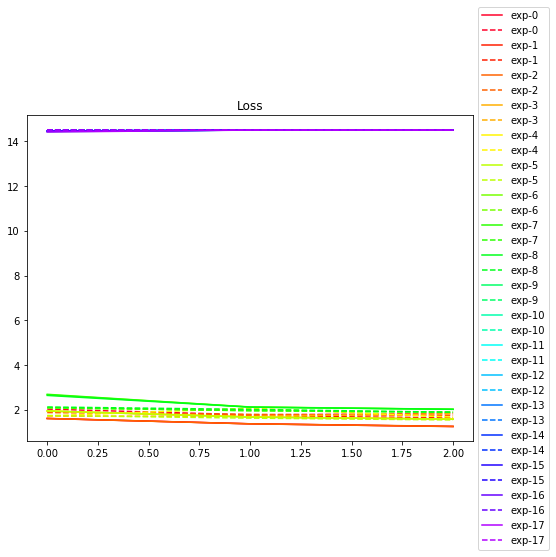

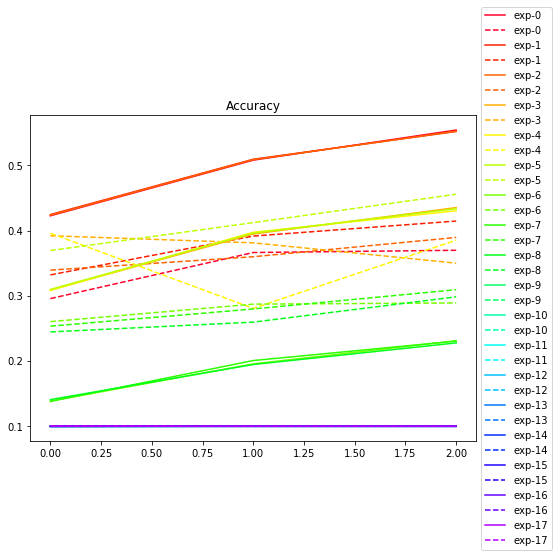

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as mplcm
import matplotlib.colors as colors
"""Code Here
將結果繪出
"""
NUM_COLORS=20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()